# Imports and configs

In [1]:
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
import matplotlib.pyplot as plt
from scipy.special import logit
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import optuna
import glob
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e10/train.csv'
    test_path = '/kaggle/input/playground-series-s4e10/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e10/sample_submission.csv'
    
    oof_path = '/kaggle/input/s04e10-loan-approval-prediction-autogluon'
    
    target = 'loan_status'
    n_folds = 5
    seed = 1859

# Loading OOF files

In [3]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]

In [4]:
def get_data(oof_path, test_oof_path):
    oof_pred_probs = pickle.load(open(oof_path, 'rb'))
    test_pred_probs = pickle.load(open(test_oof_path, 'rb'))
    
    scores = []
    skf = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
    for _, val_idx in skf.split(X, y):
        y_val = y[val_idx]
        y_pred_probs = oof_pred_probs[val_idx]   
        score = roc_auc_score(y_val, y_pred_probs)
        scores.append(score)
        
    return oof_pred_probs, test_pred_probs, scores

In [5]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [6]:
oof_paths = glob.glob(f'{CFG.oof_path}/oof_pred_probs/**')
test_oof_paths = glob.glob(f'{CFG.oof_path}/test_pred_probs/**')
for oof_path, test_oof_path in zip(oof_paths, test_oof_paths):
    model_name = oof_path.split('/')[-1][:-28]
    if "L1" in model_name:
        oof_pred_probs[model_name], test_pred_probs[model_name], scores[model_name] = get_data(oof_path, test_oof_path)

# L2 Logistic Regression

In [7]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            iters = model.n_iter_
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict(X_test) if isinstance(self.model, Ridge) else model.predict_proba(X_test)[:, 1]
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - AUC: {score:.6f}' + ('' if isinstance(self.model, Ridge) else f' ({iters[0]} iterations)'))
            
        overall_score = roc_auc_score(y, oof_pred_probs)
        
        print(f'\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}')   
        
        return oof_pred_probs, test_pred_probs, scores
    
    def fit(self, X, y):
        scores = []                
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[:, 1]            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect() 
        
        return np.mean(scores)

In [8]:
def save_submission(name, test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)
    return sub.head()

In [9]:
l2_oof_pred_probs = {}
l2_test_pred_probs = {}

In [10]:
X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-1e-15))
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1-1e-15))

In [11]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'max_iter': 1000,
        'C': trial.suggest_float('C', 0, 5),
        'tol': trial.suggest_float('tol', 1e-7, 1e-1),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
    }
    
    model = LogisticRegression(**params)
    trainer = Trainer(model)
    return trainer.fit(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=250, n_jobs=-1)
lr_params = study.best_params

[I 2024-10-08 03:32:12,213] A new study created in memory with name: no-name-8c93f6dd-df75-4cd7-b5e8-8939dfacd612
[I 2024-10-08 03:33:29,118] Trial 3 finished with value: 0.9634542189108213 and parameters: {'C': 1.690289708778749, 'tol': 0.004071838599087621, 'fit_intercept': False}. Best is trial 3 with value: 0.9634542189108213.
[I 2024-10-08 03:33:33,909] Trial 2 finished with value: 0.9634548022952009 and parameters: {'C': 1.8964099978632136, 'tol': 0.03077516412041183, 'fit_intercept': False}. Best is trial 2 with value: 0.9634548022952009.
[I 2024-10-08 03:33:34,569] Trial 0 finished with value: 0.9634634816260709 and parameters: {'C': 1.045695117212957, 'tol': 0.03823715544837674, 'fit_intercept': False}. Best is trial 0 with value: 0.9634634816260709.
[I 2024-10-08 03:33:38,069] Trial 1 finished with value: 0.9634878766177755 and parameters: {'C': 2.7392116829237976, 'tol': 0.05829111873119928, 'fit_intercept': True}. Best is trial 1 with value: 0.9634878766177755.
[I 2024-10-0

In [12]:
lr_model = LogisticRegression(random_state=CFG.seed, max_iter=1000, **lr_params)
lr_trainer = Trainer(lr_model)
l2_oof_pred_probs['LR_Ensemble_L2'], l2_test_pred_probs['LR_Ensemble_L2'], scores['LR_Ensemble_L2'] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - AUC: 0.966968 (159 iterations)
--- Fold 2 - AUC: 0.964917 (156 iterations)
--- Fold 3 - AUC: 0.963261 (148 iterations)
--- Fold 4 - AUC: 0.961084 (173 iterations)
--- Fold 5 - AUC: 0.962931 (167 iterations)

------ Overall: 0.963847 | Average: 0.963833 ± 0.001985


In [13]:
save_submission('lr-ensemble-l2', l2_test_pred_probs['LR_Ensemble_L2'], np.mean(scores['LR_Ensemble_L2']))

,id,loan_status
0,58645,0.998527
1,58646,0.036080
2,58647,0.549960
3,58648,0.012556
4,58649,0.070557


# L2 Ridge

In [14]:
X = pd.DataFrame(oof_pred_probs)
X_test = pd.DataFrame(test_pred_probs)

In [15]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 50),
        'tol': trial.suggest_float('tol', 1e-7, 1e-1),
        'positive': trial.suggest_categorical('positive', [True, False]),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
    }
    
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.fit(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=250, n_jobs=-1)
ridge_params = study.best_params

[I 2024-10-08 04:40:29,985] A new study created in memory with name: no-name-9cc91789-1d51-4540-9cae-6f37db343edb
[I 2024-10-08 04:40:33,006] Trial 3 finished with value: 0.9628559760883839 and parameters: {'alpha': 4.938160208216829, 'tol': 0.0903004053648445, 'positive': False, 'fit_intercept': True}. Best is trial 3 with value: 0.9628559760883839.
[I 2024-10-08 04:40:33,143] Trial 2 finished with value: 0.9633288388924506 and parameters: {'alpha': 15.60089085842819, 'tol': 0.01184201284099401, 'positive': False, 'fit_intercept': False}. Best is trial 2 with value: 0.9633288388924506.
[I 2024-10-08 04:40:33,392] Trial 0 finished with value: 0.9613832162695187 and parameters: {'alpha': 43.02217827846183, 'tol': 0.043980852565212475, 'positive': True, 'fit_intercept': False}. Best is trial 2 with value: 0.9633288388924506.
[I 2024-10-08 04:40:33,553] Trial 1 finished with value: 0.9613832043637152 and parameters: {'alpha': 38.578911167716825, 'tol': 0.04407677947861541, 'positive': Tru

In [16]:
ridge_model = Ridge(random_state=CFG.seed, **ridge_params)
ridge_trainer = Trainer(ridge_model)
l2_oof_pred_probs['Ridge_Ensemble_L2'], l2_test_pred_probs['Ridge_Ensemble_L2'], scores['Ridge_Ensemble_L2'] = ridge_trainer.fit_predict(X, y, X_test)

Training Ridge

--- Fold 1 - AUC: 0.966498
--- Fold 2 - AUC: 0.964916
--- Fold 3 - AUC: 0.963238
--- Fold 4 - AUC: 0.959991
--- Fold 5 - AUC: 0.962652

------ Overall: 0.963423 | Average: 0.963459 ± 0.002195


In [17]:
save_submission('ridge-ensemble-l2', l2_test_pred_probs['Ridge_Ensemble_L2'], np.mean(scores['Ridge_Ensemble_L2']))

,id,loan_status
0,58645,0.983159
1,58646,0.028097
2,58647,0.569347
3,58648,0.010938
4,58649,0.077267


# L3 Weighted ensemble

In [18]:
def objective(trial):
    weights = [trial.suggest_float(l2_model_name, 0, 1) for l2_model_name in l2_oof_pred_probs.keys()]
    weights /= np.sum(weights)
    weights = [round(w, 3) for w in weights]
    
    preds = np.zeros(X.shape[0])
    for model, weight in zip(l2_oof_pred_probs.keys(), weights):
        preds += l2_oof_pred_probs[model] * weight
    
    return roc_auc_score(y.values, preds)

sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2024-10-08 04:44:19,033] A new study created in memory with name: no-name-0c4d98f5-72ae-42c7-bfcc-1689079217fb
[I 2024-10-08 04:44:19,071] Trial 0 finished with value: 0.9638576137316777 and parameters: {'LR_Ensemble_L2': 0.31923689978751846, 'Ridge_Ensemble_L2': 0.42969052703084176}. Best is trial 0 with value: 0.9638576137316777.
[I 2024-10-08 04:44:19,079] Trial 1 finished with value: 0.9637198278658906 and parameters: {'LR_Ensemble_L2': 0.29169167518957595, 'Ridge_Ensemble_L2': 0.9070315451896181}. Best is trial 0 with value: 0.9638576137316777.
[I 2024-10-08 04:44:19,084] Trial 2 finished with value: 0.9639061417874065 and parameters: {'LR_Ensemble_L2': 0.728523697205824, 'Ridge_Ensemble_L2': 0.6654548259392378}. Best is trial 2 with value: 0.9639061417874065.
[I 2024-10-08 04:44:19,087] Trial 3 finished with value: 0.9635780368877516 and parameters: {'LR_Ensemble_L2': 0.048080974975611146, 'Ridge_Ensemble_L2': 0.3772279348835105}. Best is trial 2 with value: 0.9639061417874065

In [19]:
scores['Weighted_Ensemble_L3'] = [study.best_value] * CFG.n_folds

In [20]:
best_weights = study.best_params
best_weights = [best_weights[l2_model] for l2_model in l2_oof_pred_probs.keys()]
best_weights /= np.sum(best_weights)
best_weights = [round(w, 3) for w in best_weights]

print("Ensemble weights:")
for i, model in enumerate(study.best_params.keys()):
    print(f"--- {model}: {best_weights[i]}")

Ensemble weights:
--- LR_Ensemble_L2: 0.785
--- Ridge_Ensemble_L2: 0.215


In [21]:
weighted_test_preds = np.zeros((X_test.shape[0]))
for model, weight in zip(l2_test_pred_probs.keys(), best_weights):
    weighted_test_preds += l2_test_pred_probs[model] * weight

In [22]:
save_submission('weighted-ensemble-l3', weighted_test_preds, np.mean(scores['Weighted_Ensemble_L3']))

,id,loan_status
0,58645,0.995223
1,58646,0.034364
2,58647,0.554129
3,58648,0.012208
4,58649,0.072000


# Results

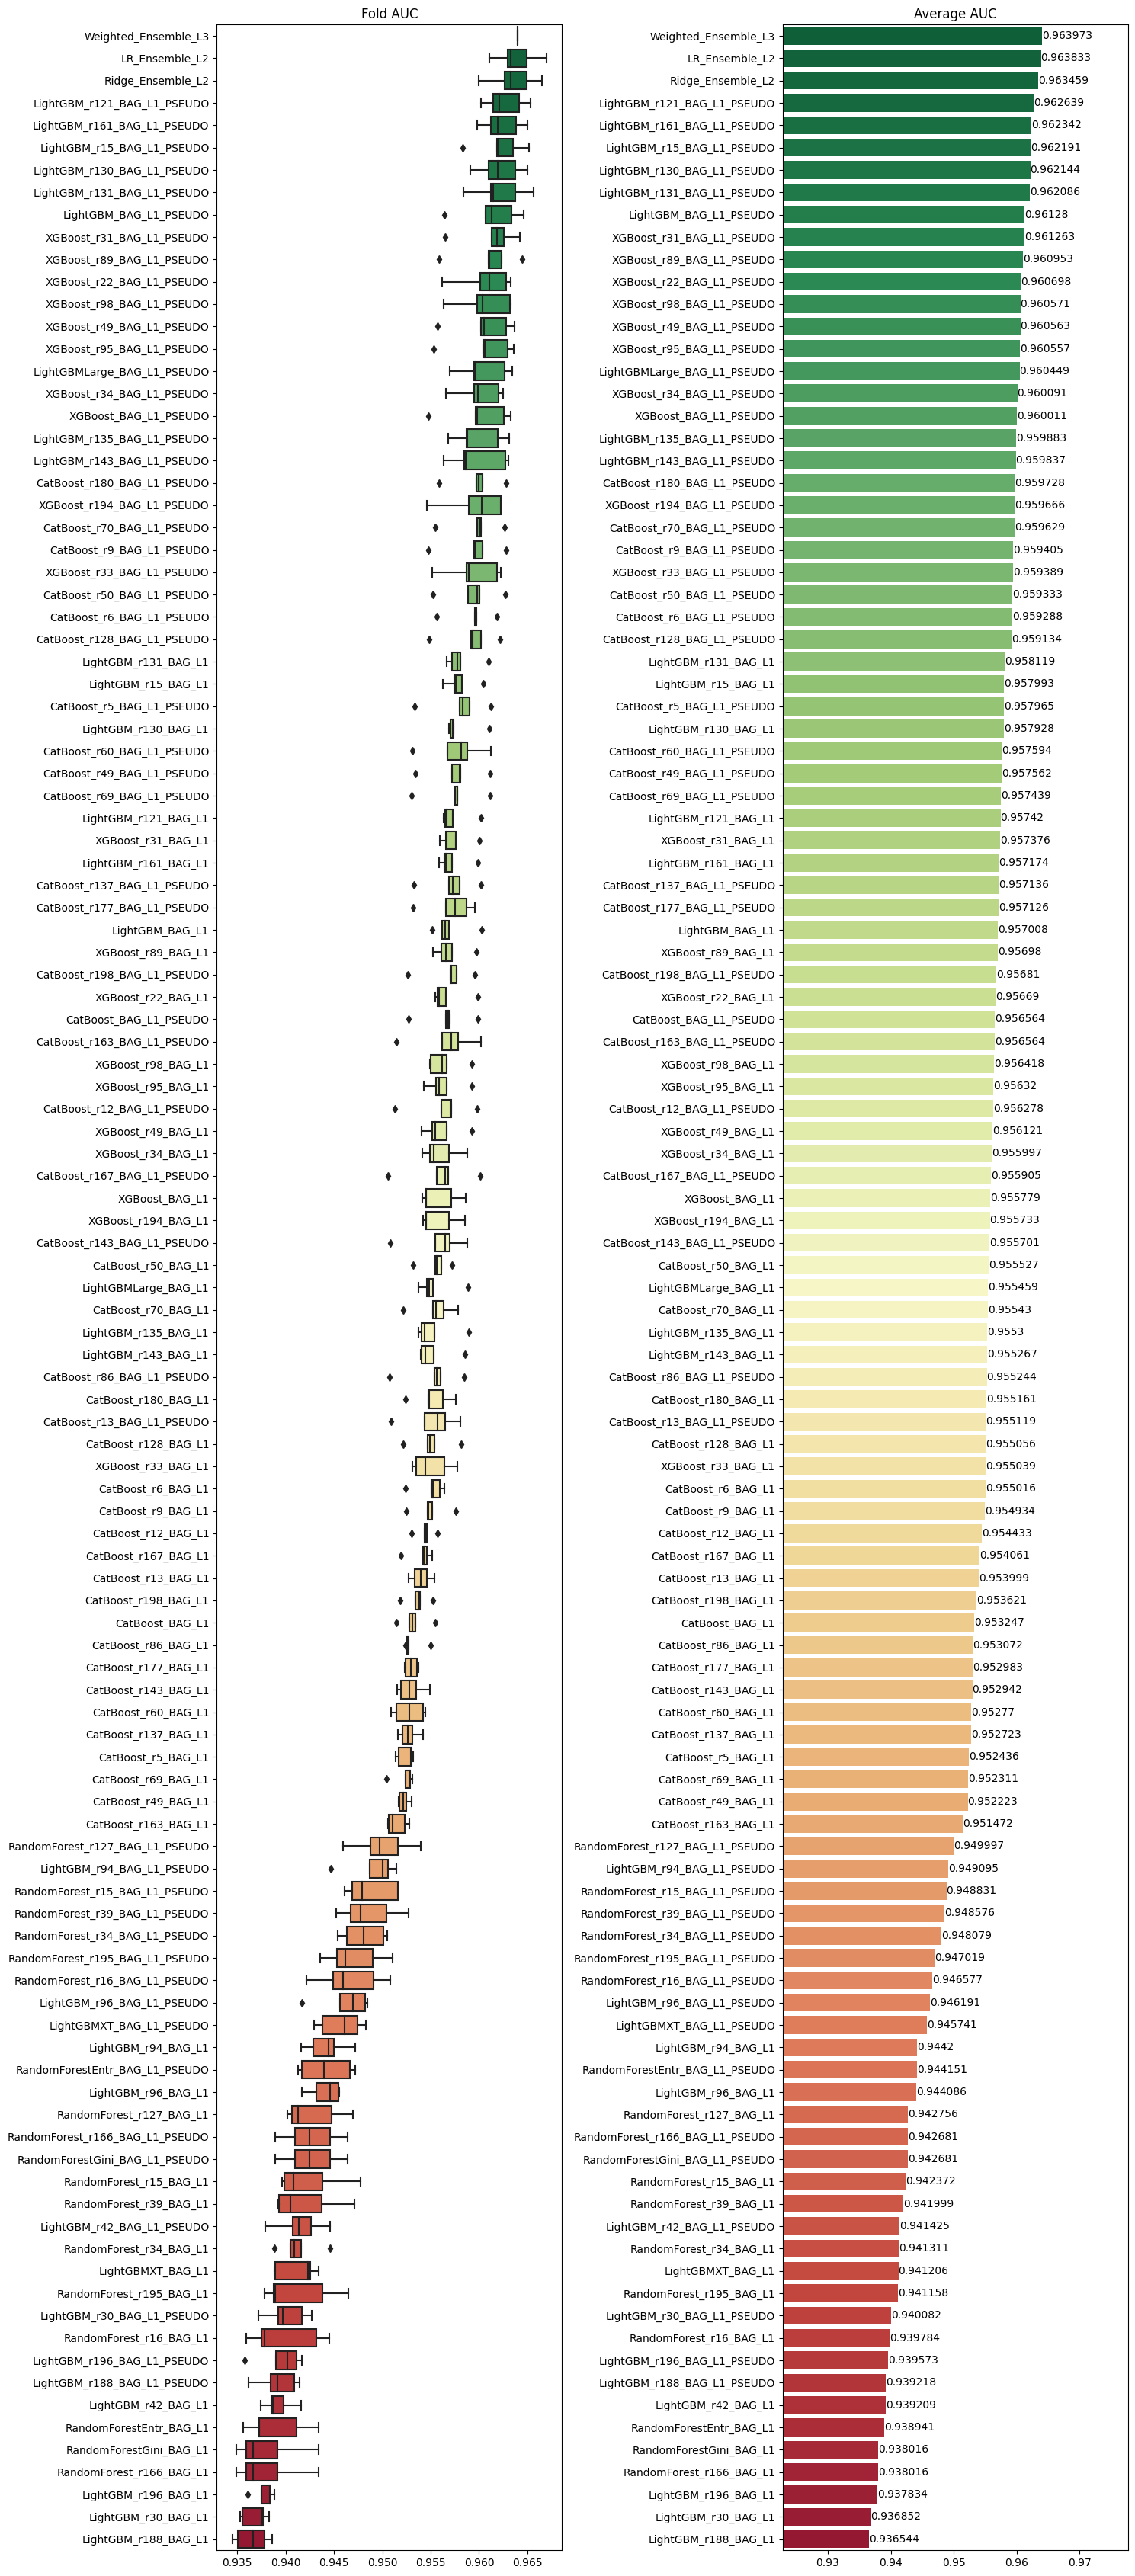

In [23]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette='RdYlGn_r')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette='RdYlGn_r')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 6), va='center')

plt.tight_layout()
plt.show()